# HW 5

References:
*   https://keras.io/examples/generative/vae/


Discussed and Colaborated with : Ramki, Rahul and sushant

##GPU Check

In [ ]:
#Path: TensorFlow/Tejas/
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.9.2


In [ ]:
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
4.919598944999997
GPU (s):
0.051543502999990665
GPU speedup over CPU: 95x


##Dependencies

In [ ]:
import numpy as np
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Model
import keras.utils
from keras import utils as np_utils
from keras.models import Sequential
from keras.layers import  Dense, Dropout, Activation, Flatten
from librosa.core import stft,istft
import soundfile as sf
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
import librosa
%matplotlib inline

##Load Dataset

In [ ]:
#Dependencies for Loading data 

import gzip
import pickle
import random
from itertools import combinations,product

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open('/content/drive/MyDrive/ENGR-E-533 /DATA/HW5/hw5_tr7.pkl', 'rb') as f:
    train_data = pickle.load(f)

In [ ]:
type(train_data)

numpy.ndarray

In [ ]:
#X_train[:10]

In [ ]:
with open('/content/drive/MyDrive/ENGR-E-533 /DATA/HW5/hw5_te7.pkl', 'rb') as f:
    test_data = pickle.load(f)

In [ ]:
print("X_train shape is {} and y_train shape is {} ".format(train_data.shape,test_data.shape))

X_train shape is (6265, 28, 28) and y_train shape is (1028, 28, 28) 


##VAE Code Start


###Sampling

In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

###Model

##Why I chose FCN instead of CNN, even though CNN is better


*   So I know that Encoder and Decoder should work **amazingly well with a Convolution Network** because of how **filters** work and how that **feaures are handled**. We visualized this aspect in **one of our homeworks**. 
*   But I do not want to keep experimenting with different number of filters, layers , windowsize, padding. So to save time i just use simple fully connected layers.



*   In Encoder i will **progressively reduce** the nodes as I see each node to be the **best cummulation** of all **judegments **taken by previous nodes. This should kind of be similar to a CNN as we reduce the nodes, My intuition is that the **features will be captured in the right way** and encoded.
*   Tradeoff is that encoding will be better in CNN as we reduce size and expand using dot product. But for simplicity I use Vanilla FCN ( without dropout )



*   Though Dropout would be amazing for this task but will require more epochs to get it right.


In [ ]:
latent_dim = 3

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Flatten()(encoder_inputs)
x = layers.Dense(1024, activation="gelu")(x),
x = layers.Dense(612, activation="gelu")(x[0]),
x = layers.Dense(256, activation="gelu")(x[0]),
x = layers.Dense(64, activation="gelu")(x[0]),
x = layers.Dense(32, activation="gelu")(x[0]),
z_mean = layers.Dense(latent_dim, name="z_mean")(x[0])
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x[0])
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 flatten_1 (Flatten)            (None, 784)          0           ['input_2[0][0]']                
                                                                                                  
 dense_5 (Dense)                (None, 1024)         803840      ['flatten_1[0][0]']              
                                                                                                  
 dense_6 (Dense)                (None, 612)          627300      ['dense_5[0][0]']                
                                                                                            

In [ ]:

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(1024, activation="gelu")(latent_inputs),
x = layers.Dense(1024, activation="gelu")(x[0]),
x = layers.Dense(1024, activation="gelu")(x[0]),
x = layers.Dense(1024, activation="gelu")(x[0]),
x = layers.Dense(1024, activation="gelu")(x[0]),
decoder_outputs = layers.Dense(784, activation="sigmoid")(x[0])
outputs = keras.layers.Reshape(target_shape=(28,28,1),input_shape=(784,))(decoder_outputs)
decoder = keras.Model(latent_inputs, outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense_10 (Dense)            (None, 1024)              4096      
                                                                 
 dense_11 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_12 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_13 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_14 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_15 (Dense)            (None, 784)               8036

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [ ]:
mnist_digits = np.concatenate([train_data, test_data], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32")

In [ ]:
mnist_digits.shape

(7293, 28, 28, 1)

In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=30, batch_size=128)

Epoch 1/30
57/57 [==============================] - 2s 8ms/step - loss: 303.0280 - reconstruction_loss: 225.3033 - kl_loss: 4.3563
Epoch 2/30
57/57 [==============================] - 0s 7ms/step - loss: 189.7700 - reconstruction_loss: 183.3959 - kl_loss: 1.8034
Epoch 3/30
57/57 [==============================] - 0s 8ms/step - loss: 167.5897 - reconstruction_loss: 157.9459 - kl_loss: 3.6538
Epoch 4/30
57/57 [==============================] - 0s 7ms/step - loss: 143.9385 - reconstruction_loss: 137.3728 - kl_loss: 4.7653
Epoch 5/30
57/57 [==============================] - 0s 8ms/step - loss: 138.3104 - reconstruction_loss: 130.9685 - kl_loss: 5.2030
Epoch 6/30
57/57 [==============================] - 0s 7ms/step - loss: 131.8245 - reconstruction_loss: 123.7772 - kl_loss: 6.3177
Epoch 7/30
57/57 [==============================] - 0s 8ms/step - loss: 125.9083 - reconstruction_loss: 118.6873 - kl_loss: 6.7928
Epoch 8/30
57/57 [==============================] - 0s 7ms/step - loss: 122.3392 - 

#Plotting

##Keep 2 dimensions constant and change 1 Dimension

###Change first dimension

In [ ]:
  ##Dimension 1
  
  dim1 = np.repeat(tf.random.normal([1],mean=0,stddev=1,seed=1),10)
  dim2 = np.repeat(tf.random.normal([1],mean=0,stddev=1,seed=2),10)
  dim3 = np.linspace(-5.0,5.0,10)
  input_to_decoder = np.array([dim3,dim1,dim2]).T
  outputs_dim1 = decoder.predict(input_to_decoder).reshape(-1,28,28)

1/1 [==============================] - 0s 18ms/step


In [ ]:
outputs_dim1.shape

(10, 28, 28)

In [ ]:
outputs_dim1

array([[[9.68304326e-11, 6.51148913e-10, 9.67302460e-10, ...,
         1.18149845e-09, 4.57929084e-10, 5.36796607e-10],
        [5.66714320e-09, 5.33136535e-10, 2.79117240e-09, ...,
         5.73516734e-10, 2.23927366e-09, 7.39237394e-10],
        [7.98757505e-10, 2.44199736e-08, 6.03611872e-09, ...,
         9.76302927e-11, 2.05564143e-09, 1.04751701e-08],
        ...,
        [9.14193610e-10, 2.33143616e-09, 9.16965437e-09, ...,
         1.00939479e-09, 9.81757897e-10, 5.82722814e-10],
        [8.83092266e-10, 2.41392795e-09, 1.27605537e-09, ...,
         1.50134488e-10, 6.80263446e-09, 2.34155806e-08],
        [4.45276029e-08, 2.19489138e-08, 1.78961148e-08, ...,
         1.48628401e-10, 9.35917677e-10, 2.86232565e-10]],

       [[5.32343281e-09, 2.48112517e-08, 2.60898982e-08, ...,
         4.71319979e-08, 1.63947309e-08, 1.49593831e-08],
        [7.83701850e-08, 1.38316585e-08, 6.45676934e-08, ...,
         2.27716441e-08, 5.19370431e-08, 2.71263563e-08],
        [2.43787870e-08, 

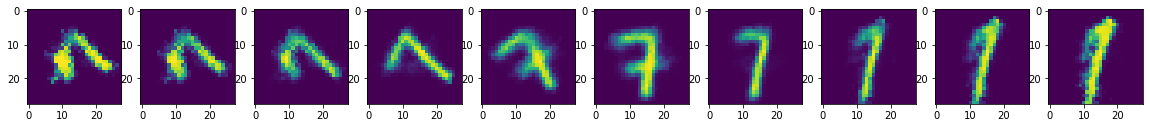

In [ ]:
fig,ax = plt.subplots(nrows = 1,ncols = 10, figsize = (20,20))

for row in range(10):
  ax[row ].imshow(outputs_dim1[row].reshape(28,28))


###Change second Dimension

In [ ]:
  ##Dimension 2
  ##Simply change way the val are passed to decoder
  
  dim1 = np.repeat(tf.random.normal([1],mean=0,stddev=1,seed=1),10)
  dim2 = np.repeat(tf.random.normal([1],mean=0,stddev=1,seed=2),10)
  dim3 = np.linspace(-5.0,5.0,10)
  input_to_decoder = np.array([dim1,dim3,dim2]).T
  outputs_dim2 = decoder.predict(input_to_decoder).reshape(-1,28,28)

1/1 [==============================] - 0s 15ms/step


In [ ]:
outputs_dim2.shape

(10, 28, 28)

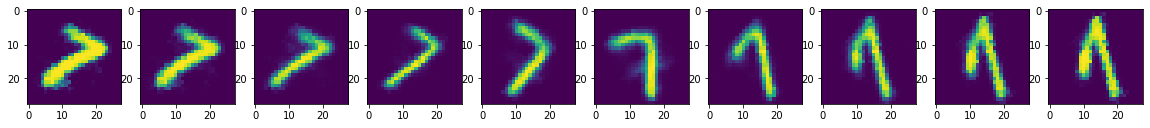

In [ ]:
fig,ax = plt.subplots(nrows = 1,ncols = 10, figsize = (20,20))

for row in range(10):
  ax[row ].imshow(outputs_dim2[row].reshape(28,28))


###Change dimension 3 

In [ ]:
  ##Dimension 3
  ##Simply change way the val are passed to decoder
  
  dim1 = np.repeat(tf.random.normal([1],mean=0,stddev=1,seed=1),10)
  dim2 = np.repeat(tf.random.normal([1],mean=0,stddev=1,seed=2),10)
  dim3 = np.linspace(-5.0,5.0,10)
  input_to_decoder = np.array([dim1,dim2,dim3]).T
  outputs_dim3 = decoder.predict(input_to_decoder).reshape(-1,28,28)

1/1 [==============================] - 0s 15ms/step


In [ ]:
outputs_dim3.shape

(10, 28, 28)

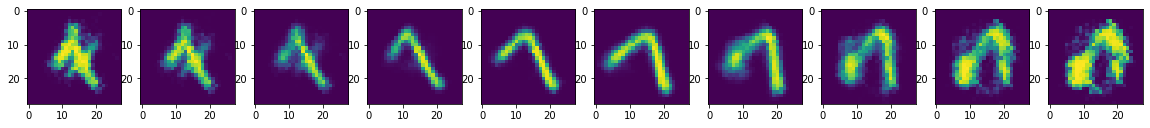

In [ ]:
fig,ax = plt.subplots(nrows = 1,ncols = 10, figsize = (20,20))

for row in range(10):
  ax[row ].imshow(outputs_dim3[row].reshape(28,28))

The images generated follows the trend and observations given in the question.

In [ ]:
%%shell
jupyter nbconvert --to html 